이번 프로젝트는 지금까지의 실습과 동일한 방법으로 CIFAR-10 데이터셋에 대해 진행해 보겠습니다. 여러분들이 만들어야 할 모델은 CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경고를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

- 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계산, 감지 성공/실패사례 시각화 포함)

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

train_data.shape

(50000, 32, 32, 3)

In [4]:
train_data_backup = train_data[:]

In [5]:
print("max pixel:", train_data.max())
print("min pixel:", train_data.min())

max pixel: 255
min pixel: 0


In [6]:
def normalization(train_data):

    normalized_train_data = (train_data - 127.5) / 127.5
    
    return normalized_train_data

In [7]:
train_data = normalization(train_data)

print("max pixel:", train_data.max())
print("min pixel:", train_data.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_data.shape

(50000, 32, 32, 3)

In [9]:
test_data.shape

(10000, 32, 32, 3)

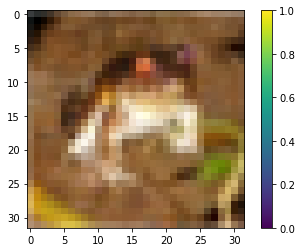

In [11]:
plt.imshow((train_data[0].reshape(32, 32, 3)+1)/2)
plt.colorbar()
plt.show()

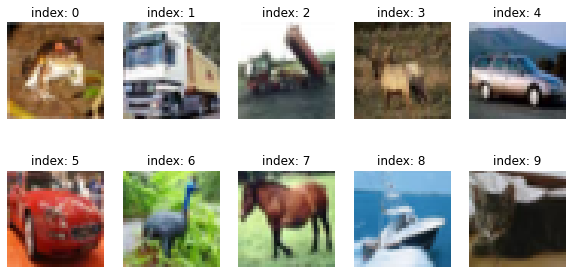

In [12]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_data[i].reshape(32, 32, 3)+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [13]:
print(train_labels[0])

[6]


In [14]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # frog: 6
            new_t_labels.append([0])  # Frog 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [15]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [16]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [17]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [18]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [19]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [20]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [21]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [23]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


### Generator

In [24]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [25]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [26]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator

In [27]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

### 전체 모델 구성

In [28]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X3 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

### Loss 함수

In [29]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [30]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [31]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [32]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

### Model Train

In [33]:
@tf.function()
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [34]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 17.221202850341797, 	 Total Dis Loss : 0.6876643300056458
Steps : 200, 	 Total Gen Loss : 14.107324600219727, 	 Total Dis Loss : 0.5261241793632507
Steps : 300, 	 Total Gen Loss : 13.918658256530762, 	 Total Dis Loss : 0.43970656394958496
Steps : 400, 	 Total Gen Loss : 15.863085746765137, 	 Total Dis Loss : 0.11770561337471008
Steps : 500, 	 Total Gen Loss : 18.69468116760254, 	 Total Dis Loss : 0.09753168374300003
Steps : 600, 	 Total Gen Loss : 16.91179084777832, 	 Total Dis Loss : 0.2538461685180664
Steps : 700, 	 Total Gen Loss : 15.974733352661133, 	 Total Dis Loss : 0.06814403086900711
Steps : 800, 	 Total Gen Loss : 18.196239471435547, 	 Total Dis Loss : 0.16496649384498596
Steps : 900, 	 Total Gen Loss : 16.33879852294922, 	 Total Dis Loss : 0.20363202691078186
Steps : 1000, 	 Total Gen Loss : 20.265602111816406, 	 Total Dis Loss : 0.1821017563343048
Steps : 1100, 	 Total Gen Loss : 20.07366371154785, 	 Total Dis Loss : 0.06295118480920792
Steps

Steps : 9000, 	 Total Gen Loss : 24.15283966064453, 	 Total Dis Loss : 0.003947913646697998
Steps : 9100, 	 Total Gen Loss : 21.407514572143555, 	 Total Dis Loss : 0.0022330074571073055
Steps : 9200, 	 Total Gen Loss : 24.265722274780273, 	 Total Dis Loss : 0.0006838716799393296
Steps : 9300, 	 Total Gen Loss : 28.25703239440918, 	 Total Dis Loss : 0.0024464288726449013
Steps : 9400, 	 Total Gen Loss : 27.92479133605957, 	 Total Dis Loss : 0.0018356989603489637
Steps : 9500, 	 Total Gen Loss : 23.403928756713867, 	 Total Dis Loss : 0.002721863565966487
Steps : 9600, 	 Total Gen Loss : 25.1699275970459, 	 Total Dis Loss : 0.0013967279810458422
Steps : 9700, 	 Total Gen Loss : 21.456758499145508, 	 Total Dis Loss : 0.0013111945008859038
Steps : 9800, 	 Total Gen Loss : 23.739227294921875, 	 Total Dis Loss : 0.0016619410598650575
Steps : 9900, 	 Total Gen Loss : 22.951465606689453, 	 Total Dis Loss : 0.0010852718260139227
Steps : 10000, 	 Total Gen Loss : 24.833843231201172, 	 Total Dis L

Steps : 17700, 	 Total Gen Loss : 26.450645446777344, 	 Total Dis Loss : 0.0017892573960125446
Steps : 17800, 	 Total Gen Loss : 26.183679580688477, 	 Total Dis Loss : 0.029391707852482796
Steps : 17900, 	 Total Gen Loss : 26.6033992767334, 	 Total Dis Loss : 0.004501688294112682
Steps : 18000, 	 Total Gen Loss : 25.691368103027344, 	 Total Dis Loss : 0.009449385106563568
Steps : 18100, 	 Total Gen Loss : 21.722253799438477, 	 Total Dis Loss : 0.0012457312550395727
Steps : 18200, 	 Total Gen Loss : 23.85072898864746, 	 Total Dis Loss : 0.12988826632499695
Steps : 18300, 	 Total Gen Loss : 25.26854133605957, 	 Total Dis Loss : 0.0006623233202844858
Steps : 18400, 	 Total Gen Loss : 24.33901596069336, 	 Total Dis Loss : 0.0008553708903491497
Steps : 18500, 	 Total Gen Loss : 25.115272521972656, 	 Total Dis Loss : 0.0005288789398036897
Steps : 18600, 	 Total Gen Loss : 20.57918357849121, 	 Total Dis Loss : 0.003491668961942196
Steps : 18700, 	 Total Gen Loss : 21.96249008178711, 	 Total D

Steps : 26400, 	 Total Gen Loss : 23.352590560913086, 	 Total Dis Loss : 0.0005842629470862448
Steps : 26500, 	 Total Gen Loss : 23.618667602539062, 	 Total Dis Loss : 0.000383949518436566
Steps : 26600, 	 Total Gen Loss : 26.00638771057129, 	 Total Dis Loss : 0.0006052502430975437
Steps : 26700, 	 Total Gen Loss : 25.210039138793945, 	 Total Dis Loss : 0.00036206666845828295
Steps : 26800, 	 Total Gen Loss : 22.721649169921875, 	 Total Dis Loss : 0.00038393508293665946
Steps : 26900, 	 Total Gen Loss : 24.18467140197754, 	 Total Dis Loss : 0.0002052805502898991
Steps : 27000, 	 Total Gen Loss : 29.69091033935547, 	 Total Dis Loss : 0.00018896741676144302
Steps : 27100, 	 Total Gen Loss : 24.654197692871094, 	 Total Dis Loss : 0.006058487109839916
Steps : 27200, 	 Total Gen Loss : 25.3968563079834, 	 Total Dis Loss : 0.0010078834602609277
Steps : 27300, 	 Total Gen Loss : 24.335186004638672, 	 Total Dis Loss : 0.0011854812037199736
Steps : 27400, 	 Total Gen Loss : 24.29674530029297, 	

Steps : 35000, 	 Total Gen Loss : 24.799808502197266, 	 Total Dis Loss : 0.0027087824419140816
Steps : 35100, 	 Total Gen Loss : 27.36859130859375, 	 Total Dis Loss : 0.00040733569767326117
Steps : 35200, 	 Total Gen Loss : 27.330171585083008, 	 Total Dis Loss : 0.00026001123478636146
Steps : 35300, 	 Total Gen Loss : 24.631778717041016, 	 Total Dis Loss : 0.00046615995233878493
Steps : 35400, 	 Total Gen Loss : 23.750324249267578, 	 Total Dis Loss : 0.0016940662171691656
Steps : 35500, 	 Total Gen Loss : 23.381420135498047, 	 Total Dis Loss : 0.001331103267148137
Steps : 35600, 	 Total Gen Loss : 20.548086166381836, 	 Total Dis Loss : 0.0007146018906496465
Steps : 35700, 	 Total Gen Loss : 20.652931213378906, 	 Total Dis Loss : 0.0008237104048021138
Steps : 35800, 	 Total Gen Loss : 25.780323028564453, 	 Total Dis Loss : 0.0006210795254446566
Steps : 35900, 	 Total Gen Loss : 18.40245819091797, 	 Total Dis Loss : 0.0025647771544754505
Steps : 36000, 	 Total Gen Loss : 22.9724617004394

Steps : 43600, 	 Total Gen Loss : 25.79257583618164, 	 Total Dis Loss : 8.082261774688959e-05
Steps : 43700, 	 Total Gen Loss : 23.542339324951172, 	 Total Dis Loss : 0.00024082321033347398
Steps : 43800, 	 Total Gen Loss : 21.555315017700195, 	 Total Dis Loss : 0.00043093872955068946
Steps : 43900, 	 Total Gen Loss : 28.156862258911133, 	 Total Dis Loss : 0.00017031459719873965
Steps : 44000, 	 Total Gen Loss : 25.420541763305664, 	 Total Dis Loss : 0.0001536016061436385
Steps : 44100, 	 Total Gen Loss : 27.09189796447754, 	 Total Dis Loss : 9.833676449488848e-05
Steps : 44200, 	 Total Gen Loss : 25.383277893066406, 	 Total Dis Loss : 0.00015597883611917496
Steps : 44300, 	 Total Gen Loss : 25.180959701538086, 	 Total Dis Loss : 0.00012869543570559472
Steps : 44400, 	 Total Gen Loss : 24.981863021850586, 	 Total Dis Loss : 0.0005701914196833968
Steps : 44500, 	 Total Gen Loss : 26.834636688232422, 	 Total Dis Loss : 0.0004013697907794267
Steps : 44600, 	 Total Gen Loss : 24.8896598815

Steps : 52200, 	 Total Gen Loss : 23.45004653930664, 	 Total Dis Loss : 0.0017936236690729856
Steps : 52300, 	 Total Gen Loss : 24.556236267089844, 	 Total Dis Loss : 0.0002952822542283684
Steps : 52400, 	 Total Gen Loss : 25.95597267150879, 	 Total Dis Loss : 0.0010531081352382898
Steps : 52500, 	 Total Gen Loss : 23.683639526367188, 	 Total Dis Loss : 0.0007825231296010315
Steps : 52600, 	 Total Gen Loss : 27.7427921295166, 	 Total Dis Loss : 0.00024020041746553034
Steps : 52700, 	 Total Gen Loss : 23.44312286376953, 	 Total Dis Loss : 0.0013536206679418683
Steps : 52800, 	 Total Gen Loss : 24.933977127075195, 	 Total Dis Loss : 0.0002524067531339824
Steps : 52900, 	 Total Gen Loss : 23.627147674560547, 	 Total Dis Loss : 0.00030611446709372103
Steps : 53000, 	 Total Gen Loss : 25.91587257385254, 	 Total Dis Loss : 0.00040553859435021877
Steps : 53100, 	 Total Gen Loss : 25.085918426513672, 	 Total Dis Loss : 0.0008336673490703106
Steps : 53200, 	 Total Gen Loss : 23.824604034423828,

Steps : 60800, 	 Total Gen Loss : 22.237974166870117, 	 Total Dis Loss : 0.010370917618274689
Steps : 60900, 	 Total Gen Loss : 24.544410705566406, 	 Total Dis Loss : 0.00033535188413225114
Steps : 61000, 	 Total Gen Loss : 23.790388107299805, 	 Total Dis Loss : 0.0006505047203972936
Steps : 61100, 	 Total Gen Loss : 22.88066291809082, 	 Total Dis Loss : 0.0003725477436091751
Steps : 61200, 	 Total Gen Loss : 24.766010284423828, 	 Total Dis Loss : 0.0004192097985651344
Steps : 61300, 	 Total Gen Loss : 26.763547897338867, 	 Total Dis Loss : 0.0001428571413271129
Steps : 61400, 	 Total Gen Loss : 27.224483489990234, 	 Total Dis Loss : 0.00015292223542928696
Steps : 61500, 	 Total Gen Loss : 24.01025390625, 	 Total Dis Loss : 0.0002114741801051423
Steps : 61600, 	 Total Gen Loss : 23.118764877319336, 	 Total Dis Loss : 0.0012941784225404263
Steps : 61700, 	 Total Gen Loss : 24.415578842163086, 	 Total Dis Loss : 0.0004097276250831783
Steps : 61800, 	 Total Gen Loss : 22.489898681640625, 

Steps : 69400, 	 Total Gen Loss : 26.361732482910156, 	 Total Dis Loss : 0.00023561058333143592
Steps : 69500, 	 Total Gen Loss : 25.56139373779297, 	 Total Dis Loss : 0.0001331182720605284
Steps : 69600, 	 Total Gen Loss : 26.474634170532227, 	 Total Dis Loss : 0.0007820759201422334
Steps : 69700, 	 Total Gen Loss : 24.023942947387695, 	 Total Dis Loss : 0.0011013650801032782
Steps : 69800, 	 Total Gen Loss : 26.430431365966797, 	 Total Dis Loss : 0.0007194318459369242
Steps : 69900, 	 Total Gen Loss : 20.162612915039062, 	 Total Dis Loss : 0.0015642691869288683
Steps : 70000, 	 Total Gen Loss : 23.694599151611328, 	 Total Dis Loss : 0.0005635170382447541
Steps : 70100, 	 Total Gen Loss : 25.570419311523438, 	 Total Dis Loss : 0.00016308041813317686
Steps : 70200, 	 Total Gen Loss : 24.80716323852539, 	 Total Dis Loss : 0.00010261996067129076
Steps : 70300, 	 Total Gen Loss : 24.715240478515625, 	 Total Dis Loss : 0.00032617885153740644
Steps : 70400, 	 Total Gen Loss : 25.85321807861

Steps : 78100, 	 Total Gen Loss : 22.681241989135742, 	 Total Dis Loss : 0.008476444520056248
Steps : 78200, 	 Total Gen Loss : 24.230310440063477, 	 Total Dis Loss : 0.01071784645318985
Steps : 78300, 	 Total Gen Loss : 32.38615036010742, 	 Total Dis Loss : 0.0003661156806629151
Steps : 78400, 	 Total Gen Loss : 32.55577087402344, 	 Total Dis Loss : 0.0005568276974372566
Steps : 78500, 	 Total Gen Loss : 31.015853881835938, 	 Total Dis Loss : 0.0003663120442070067
Steps : 78600, 	 Total Gen Loss : 28.9790096282959, 	 Total Dis Loss : 0.0003287300933152437
Steps : 78700, 	 Total Gen Loss : 28.68724822998047, 	 Total Dis Loss : 0.003849519183859229
Time for epoch 14 is 69.01912117004395 sec
Steps : 78800, 	 Total Gen Loss : 34.16685104370117, 	 Total Dis Loss : 0.0047273035161197186
Steps : 78900, 	 Total Gen Loss : 30.505447387695312, 	 Total Dis Loss : 0.00010980638762703165
Steps : 79000, 	 Total Gen Loss : 30.079097747802734, 	 Total Dis Loss : 0.004695529583841562
Steps : 79100, 	 

Steps : 86700, 	 Total Gen Loss : 29.280521392822266, 	 Total Dis Loss : 0.00040498076123185456
Steps : 86800, 	 Total Gen Loss : 32.012001037597656, 	 Total Dis Loss : 0.0002783803502097726
Steps : 86900, 	 Total Gen Loss : 29.640594482421875, 	 Total Dis Loss : 0.0013114401372149587
Steps : 87000, 	 Total Gen Loss : 29.704097747802734, 	 Total Dis Loss : 3.160467167617753e-05
Steps : 87100, 	 Total Gen Loss : 27.271625518798828, 	 Total Dis Loss : 0.00017662244499661028
Steps : 87200, 	 Total Gen Loss : 28.84469223022461, 	 Total Dis Loss : 3.679699148051441e-05
Steps : 87300, 	 Total Gen Loss : 30.348886489868164, 	 Total Dis Loss : 0.0006254701875150204
Steps : 87400, 	 Total Gen Loss : 38.044700622558594, 	 Total Dis Loss : 0.0024850494228303432
Steps : 87500, 	 Total Gen Loss : 26.350387573242188, 	 Total Dis Loss : 0.00038449245039373636
Steps : 87600, 	 Total Gen Loss : 31.007251739501953, 	 Total Dis Loss : 0.00014344278315547854
Steps : 87700, 	 Total Gen Loss : 28.5587921142

Steps : 95400, 	 Total Gen Loss : 29.30158233642578, 	 Total Dis Loss : 0.0012563730124384165
Steps : 95500, 	 Total Gen Loss : 30.792383193969727, 	 Total Dis Loss : 0.004637191072106361
Steps : 95600, 	 Total Gen Loss : 26.82655143737793, 	 Total Dis Loss : 0.1007152870297432
Time for epoch 17 is 69.01090955734253 sec
Steps : 95700, 	 Total Gen Loss : 33.745540618896484, 	 Total Dis Loss : 0.002276881830766797
Steps : 95800, 	 Total Gen Loss : 28.283668518066406, 	 Total Dis Loss : 0.0014840855728834867
Steps : 95900, 	 Total Gen Loss : 27.417606353759766, 	 Total Dis Loss : 0.002368396846577525
Steps : 96000, 	 Total Gen Loss : 28.96259880065918, 	 Total Dis Loss : 0.001187934773042798
Steps : 96100, 	 Total Gen Loss : 30.48229217529297, 	 Total Dis Loss : 0.0008403990650549531
Steps : 96200, 	 Total Gen Loss : 26.563779830932617, 	 Total Dis Loss : 0.00017402996309101582
Steps : 96300, 	 Total Gen Loss : 30.180498123168945, 	 Total Dis Loss : 0.0014000465162098408
Steps : 96400, 	 

Steps : 104000, 	 Total Gen Loss : 30.859085083007812, 	 Total Dis Loss : 0.00014088941679801792
Steps : 104100, 	 Total Gen Loss : 27.183372497558594, 	 Total Dis Loss : 0.0012994001153856516
Steps : 104200, 	 Total Gen Loss : 29.202329635620117, 	 Total Dis Loss : 0.002120631979778409
Steps : 104300, 	 Total Gen Loss : 27.942794799804688, 	 Total Dis Loss : 0.0004033167497254908
Steps : 104400, 	 Total Gen Loss : 28.237003326416016, 	 Total Dis Loss : 0.00031087189563550055
Steps : 104500, 	 Total Gen Loss : 32.08171463012695, 	 Total Dis Loss : 0.0018552467226982117
Steps : 104600, 	 Total Gen Loss : 29.351585388183594, 	 Total Dis Loss : 0.0011391190346330404
Steps : 104700, 	 Total Gen Loss : 25.50890350341797, 	 Total Dis Loss : 0.0006382527062669396
Steps : 104800, 	 Total Gen Loss : 32.75901794433594, 	 Total Dis Loss : 0.00042760593350976706
Steps : 104900, 	 Total Gen Loss : 30.863920211791992, 	 Total Dis Loss : 0.0008131960639730096
Steps : 105000, 	 Total Gen Loss : 34.872

Steps : 112600, 	 Total Gen Loss : 28.295486450195312, 	 Total Dis Loss : 0.00048746258835308254
Steps : 112700, 	 Total Gen Loss : 28.55373764038086, 	 Total Dis Loss : 0.014646264724433422
Steps : 112800, 	 Total Gen Loss : 28.984210968017578, 	 Total Dis Loss : 0.0002704070939216763
Steps : 112900, 	 Total Gen Loss : 27.808366775512695, 	 Total Dis Loss : 0.00034577675978653133
Steps : 113000, 	 Total Gen Loss : 30.370437622070312, 	 Total Dis Loss : 0.0002704088401515037
Steps : 113100, 	 Total Gen Loss : 28.03650665283203, 	 Total Dis Loss : 0.00012375260121189058
Steps : 113200, 	 Total Gen Loss : 29.814804077148438, 	 Total Dis Loss : 0.00027427414897829294
Steps : 113300, 	 Total Gen Loss : 29.926788330078125, 	 Total Dis Loss : 9.921492164721712e-05
Steps : 113400, 	 Total Gen Loss : 26.542377471923828, 	 Total Dis Loss : 0.0004678941913880408
Steps : 113500, 	 Total Gen Loss : 25.88748550415039, 	 Total Dis Loss : 0.0008205553749576211
Steps : 113600, 	 Total Gen Loss : 32.31

Steps : 121200, 	 Total Gen Loss : 29.11285400390625, 	 Total Dis Loss : 0.0005129770142957568
Steps : 121300, 	 Total Gen Loss : 28.833194732666016, 	 Total Dis Loss : 0.00019127471023239195
Steps : 121400, 	 Total Gen Loss : 27.909038543701172, 	 Total Dis Loss : 0.0002420934324618429
Steps : 121500, 	 Total Gen Loss : 29.60148048400879, 	 Total Dis Loss : 0.00023271411191672087
Steps : 121600, 	 Total Gen Loss : 28.34048843383789, 	 Total Dis Loss : 0.001638330752030015
Steps : 121700, 	 Total Gen Loss : 32.166168212890625, 	 Total Dis Loss : 0.0004882742650806904
Steps : 121800, 	 Total Gen Loss : 29.778087615966797, 	 Total Dis Loss : 0.000655705516692251
Steps : 121900, 	 Total Gen Loss : 26.379806518554688, 	 Total Dis Loss : 0.0002054856449831277
Steps : 122000, 	 Total Gen Loss : 31.11840057373047, 	 Total Dis Loss : 0.00014132921933196485
Steps : 122100, 	 Total Gen Loss : 27.15765953063965, 	 Total Dis Loss : 0.00015589808754157275
Steps : 122200, 	 Total Gen Loss : 31.17723

Steps : 129700, 	 Total Gen Loss : 31.287399291992188, 	 Total Dis Loss : 0.00029891435406170785
Steps : 129800, 	 Total Gen Loss : 29.116920471191406, 	 Total Dis Loss : 0.0001482439402025193
Steps : 129900, 	 Total Gen Loss : 29.161792755126953, 	 Total Dis Loss : 0.00011758208711398765
Steps : 130000, 	 Total Gen Loss : 32.639076232910156, 	 Total Dis Loss : 8.261225593741983e-05
Steps : 130100, 	 Total Gen Loss : 28.107751846313477, 	 Total Dis Loss : 7.673110667383298e-05
Steps : 130200, 	 Total Gen Loss : 27.077123641967773, 	 Total Dis Loss : 7.235088560264558e-05
Steps : 130300, 	 Total Gen Loss : 28.15975570678711, 	 Total Dis Loss : 4.6208984713302925e-05
Steps : 130400, 	 Total Gen Loss : 31.890380859375, 	 Total Dis Loss : 0.00014455773634836078
Steps : 130500, 	 Total Gen Loss : 28.276506423950195, 	 Total Dis Loss : 2.7281541406409815e-05
Steps : 130600, 	 Total Gen Loss : 25.742568969726562, 	 Total Dis Loss : 0.0013357060961425304
Steps : 130700, 	 Total Gen Loss : 38.5

Steps : 138300, 	 Total Gen Loss : 29.7689208984375, 	 Total Dis Loss : 0.00019480490300338715
Steps : 138400, 	 Total Gen Loss : 26.009349822998047, 	 Total Dis Loss : 7.600161188747734e-05
Steps : 138500, 	 Total Gen Loss : 28.846965789794922, 	 Total Dis Loss : 5.506006345967762e-05
Steps : 138600, 	 Total Gen Loss : 32.240909576416016, 	 Total Dis Loss : 7.522731175413355e-05
Steps : 138700, 	 Total Gen Loss : 31.2525691986084, 	 Total Dis Loss : 5.839898585691117e-05
Steps : 138800, 	 Total Gen Loss : 29.107717514038086, 	 Total Dis Loss : 0.0002475076471455395
Steps : 138900, 	 Total Gen Loss : 28.646108627319336, 	 Total Dis Loss : 0.0005284418002702296
Steps : 139000, 	 Total Gen Loss : 26.854427337646484, 	 Total Dis Loss : 9.857624536380172e-05
Steps : 139100, 	 Total Gen Loss : 31.818538665771484, 	 Total Dis Loss : 5.2793540817219764e-05
Steps : 139200, 	 Total Gen Loss : 28.301191329956055, 	 Total Dis Loss : 0.00021318913786672056
Steps : 139300, 	 Total Gen Loss : 28.550

In [43]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [44]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [46]:
an_scores, gt_labels = _evaluate(test_dataset)

print(an_scores)

ValueError: Incompatible type conversion requested to type 'uint8' for variable of type 'float32'

In [ ]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

In [ ]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

In [ ]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))